In [1]:
!pip install transformers nlpaug


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#importing all the required libraries
import torch
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import transformers
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from joblib import Parallel, delayed,parallel_backend
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import string
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from nlpaug.util import Action

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'torch'

In [3]:
#connecting to google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
#reading the training data into a dataframe
train_df=pd.read_csv("drive/MyDrive/twitter_data.csv",encoding='iso-8859-1',names=["polarity","id","date","query","name","text"])

train_df.head()

,polarity,id,date,query,name,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
train_df.shape

(1600000, 6)

In [6]:
train_df['polarity'].value_counts()

0    800000
4    800000
Name: polarity, dtype: int64

In [7]:
concat_df=pd.concat([train_df[:10000],train_df[800000:810000]])

In [8]:
concat_df["polarity"].value_counts()

0    10000
4    10000
Name: polarity, dtype: int64

In [9]:
train_df=concat_df

In [10]:
train_df["polarity"] = train_df['polarity'].replace(4, 1)

In [11]:
X=train_df['text']
y=train_df["polarity"]

In [12]:
hate_classifier=pd.read_csv("drive/MyDrive/train.csv")
hate_classifier.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
hate_classifier=hate_classifier[:5000]

In [14]:
hate_classifier['toxic'].value_counts()

0    4497
1     503
Name: toxic, dtype: int64

In [15]:
hate_classifier['severe_toxic'].value_counts()

0    4949
1      51
Name: severe_toxic, dtype: int64

In [16]:
hate_classifier['obscene'].value_counts()

0    4730
1     270
Name: obscene, dtype: int64

In [17]:
hate_classifier['threat'].value_counts()

0    4980
1      20
Name: threat, dtype: int64

In [18]:
hate_classifier['insult'].value_counts()

0    4729
1     271
Name: insult, dtype: int64

In [19]:
hate_classifier['identity_hate'].value_counts()

0    4951
1      49
Name: identity_hate, dtype: int64

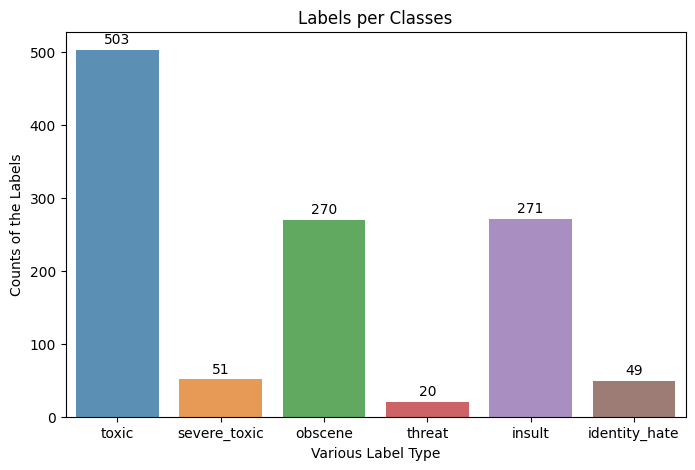

In [20]:
import seaborn as sns
labels = list(hate_classifier.columns)[2:]
targets = hate_classifier[labels].values
import matplotlib.pyplot as plt
val_counts = hate_classifier[labels].sum()
plt.figure(figsize=(8,5))
ax = sns.barplot(x=val_counts.index, y=val_counts.values, alpha=0.8)
plt.title("Labels per Classes")
plt.xlabel("Various Label Type")
plt.ylabel("Counts of the Labels")
rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")
plt.show()

In [21]:
def apply_augmentation(df,label_column, n=1):
    augmented_sentences = []
    augmented_sentences_labels = []
    aug = naw.SynonymAug(aug_src='wordnet',aug_max=10)
    for i in range(len(df)):
        if df[label_column][i] == 1:
            temps = aug.augment(df['comment_text'][i], n=n)
            for sent in temps:
                augmented_sentences.append(sent)
                augmented_sentences_labels.append(df[label_column][i])
        else:
            augmented_sentences.append(df['comment_text'][i])
            augmented_sentences_labels.append(df[label_column][i])

    augmented_data = pd.DataFrame({'comment_text': augmented_sentences, label_column: augmented_sentences_labels})
    return augmented_data

In [22]:
import math
def n_calc(label):
  val=hate_classifier[label].value_counts()[1]
  diff=len(hate_classifier)-val
  return math.ceil(diff/val)

In [23]:
n_calc("threat")

249

In [24]:
toxic_augmentation=apply_augmentation(hate_classifier,'toxic',n=n_calc("toxic"))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [25]:
sev_toxic_augmentation=apply_augmentation(hate_classifier,'severe_toxic',n=n_calc("severe_toxic"))

In [26]:
obscene_augmentation=apply_augmentation(hate_classifier,'obscene',n=n_calc("obscene"))

In [27]:
threat_augmentation=apply_augmentation(hate_classifier,'threat',n=n_calc("threat"))

In [28]:
insult_augmentation=apply_augmentation(hate_classifier,'insult',n=n_calc("insult"))

In [29]:
identity_augmentation=apply_augmentation(hate_classifier,'identity_hate',n=n_calc("identity_hate"))

In [30]:
hate_dfs=[toxic_augmentation,sev_toxic_augmentation,obscene_augmentation,threat_augmentation,insult_augmentation,identity_augmentation]

In [34]:
hate_dfs[0]['toxic'].value_counts()

1    4527
0    4497
Name: toxic, dtype: int64

In [35]:
def create_friendly_df(augmented_df, antonyms):
    friendly_df = augmented_df.copy()
    for col, antonym in antonyms.items():
        if col in friendly_df.columns:
            friendly_df[antonym] = 1 - friendly_df[col]

    return friendly_df

In [36]:
antonyms = {
    'toxic': 'safe',
    'severe_toxic': 'mild',
    'obscene': 'clean',
    'threat': 'safety',
    'insult': 'compliment',
    'identity_hate': 'tolerance'
}

friendly_dfs = []
for hate_df in hate_dfs:
    hate_df_name = hate_df.columns[1]
    antonym_name = antonyms.get(hate_df_name, hate_df_name)
    friendly_df = create_friendly_df(hate_df, antonyms)
    friendly_dfs.append(friendly_df)

In [37]:
for df_ind in range(len(friendly_dfs)):
  for key in list(antonyms.keys()):
    if key in list(friendly_dfs[df_ind].columns):
      friendly_dfs[df_ind].drop(key,axis=1,inplace=True)

In [38]:
friendly_dfs[1]

,comment_text,mild
0,Explanation\nWhy the edits made under my usern...,1
1,D'aww! He matches this background colour I'm s...,1
2,"Hey man, I'm really not trying to edit war. It...",1
3,"""\nMore\nI can't make any real suggestions on ...",1
4,"You, sir, are my hero. Any chance you remember...",1
...,...,...
9942,"""\n\nHello Marcruhwedell, and Welcome to Wikip...",1
9943,"...that's why I did ....cheers, (talk · cont...",1
9944,"No, it's not a delayed reaction\n\nI just happ...",1
9945,"""\n\nA slight difference with you\nI have to d...",1


In [39]:
X.shape

(20000,)

In [40]:
y.value_counts()

0    10000
1    10000
Name: polarity, dtype: int64

In [41]:
lemmatizer=WordNetLemmatizer()

In [42]:
def process_text(text):

    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    text = re.sub(r'$\w*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'#', '', text)
    text = str(re.sub("\S*\d\S*", "", text).strip())
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tokens = tokenizer.tokenize(text)

    texts_clean = []
    for word in tokens:
        if (word not in stopwords_english and
                word not in string.punctuation+'...'):
            stem_word = lemmatizer.lemmatize(word,"v")
            texts_clean.append(stem_word)

    return " ".join(texts_clean)

In [43]:
process_text(X[10])

'spring break plain city snow'

In [44]:
for df in hate_dfs:
    label_col = df.columns[1]
    df['comment_text'] = df['comment_text'].apply(process_text)
    df[label_col] = df[label_col].astype(int)

for df in friendly_dfs:
    label_col = df.columns[1]
    df['comment_text'] = df['comment_text'].apply(process_text)
    df[label_col] = df[label_col].astype(int)

In [45]:
all_hate_df = pd.concat(hate_dfs)
all_friendly_df = pd.concat(friendly_dfs)

In [88]:
def text_classification(col,X,y):
    results = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
    classifier = SVC(kernel='linear',probability=True)

    pipeline = Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('classifier', classifier),
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    results[col] = {
        'accuracy': accuracy,
        'classification_report': report,
        'classifier': pipeline,
    }

    return results

In [89]:
all_hate_df["toxic"].value_counts()

1.0    4527
0.0    4497
Name: toxic, dtype: int64

In [90]:
hate_models=[]
for col in list(all_hate_df.columns[1:]):
  df_filtered = all_hate_df.dropna(subset=[col], how='any')
  hate_models.append(text_classification(col,df_filtered['comment_text'],df_filtered[col]))

In [91]:
friend_models=[]
for col in list(all_friendly_df.columns[1:]):
  df_filtered = all_friendly_df.dropna(subset=[col], how='any')
  friend_models.append(text_classification(col,df_filtered['comment_text'],df_filtered[col]))

In [92]:
friend_models[0]

{'safe': {'accuracy': 0.9728531855955679,
  'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.97      0.97      0.97       898\n         1.0       0.97      0.97      0.97       907\n\n    accuracy                           0.97      1805\n   macro avg       0.97      0.97      0.97      1805\nweighted avg       0.97      0.97      0.97      1805\n',
  'classifier': Pipeline(steps=[('tfidf',
                   TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                   stop_words='english')),
                  ('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                  ('classifier', SVC(kernel='linear', probability=True))])}}

In [93]:
hate_models[0]['toxic']['classifier']

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('classifier', SVC(kernel='linear', probability=True))])

In [86]:
def classify_sentence(sentence, classifier):
    sentence = pd.Series(sentence)
    predicted_class = classifier.predict(sentence)
    probability_scores = classifier.predict_proba(sentence)
    result = {
        'predicted_class': predicted_class[0],
        'probability_scores': probability_scores.tolist()[0],
    }

    return result


In [97]:
print(classify_sentence(process_text("Where did you go to school you retard?"),hate_models[0]['toxic']['classifier']))

{'predicted_class': 1.0, 'probability_scores': [0.20087872017939565, 0.7991212798206043]}


In [98]:
X=X.apply(lambda x:process_text(str(x)))

In [99]:
X_train, X_val, y_train, y_val=train_test_split(X,y,test_size=0.2, random_state=42)

In [100]:
X_train, X_val, y_train, y_val=X_train[:10000], X_val[:10000], y_train[:10000], y_val[:10000]

We need to use BERT transformer to generate word embeddings:

In [101]:
#loading bert model and tokenizer
model_name="bert-base-uncased"
tokenizer=transformers.BertTokenizer.from_pretrained(model_name)
bert_model=transformers.BertModel.from_pretrained(model_name)

In [102]:
def conv_to_tensor(text,max_len):
  tokenized_arr=tokenizer.encode(text,add_special_tokens=True)[:max_len]
  padded_arr=np.array(tokenized_arr+[0]*(max_len-len(tokenized_arr)))
  return padded_arr

In [104]:
X_train

5894      part two hp saga black cartridge buy way back ...
3728      many question next battlestations podcast we'l...
8958      put dog sleep like years trip every time come ...
7671      remember laundry lament last night well still ...
5999      can't believe cold outside april spring hot wi...
                                ...                        
798                   stress always culminate physical pain
6232      hmm look like twitter try catch keep say capacity
734                         sad unexpected totally cry haha
804200                          would love download cd bend
2244      gawd laptop fuck system error use lil brother'...
Name: text, Length: 10000, dtype: object

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [106]:
embeddings=[]
embeddings.append(Parallel(n_jobs=-1)(delayed(conv_to_tensor)(text,100) for text in X_train))

In [107]:
embeddings=torch.squeeze(torch.tensor(embeddings,dtype=torch.float32)).long().to(device)

In [108]:
embeddings.shape

torch.Size([10000, 100])

In [109]:
print(embeddings)

tensor([[  101,  2112,  2048,  ...,     0,     0,     0],
        [  101,  2116,  3160,  ...,     0,     0,     0],
        [  101,  2404,  3899,  ...,     0,     0,     0],
        ...,
        [  101,  6517,  9223,  ...,     0,     0,     0],
        [  101,  2052,  2293,  ...,     0,     0,     0],
        [  101, 11721, 21724,  ...,     0,     0,     0]], device='cuda:0')


In [110]:
val_embeddings=[]
val_embeddings.append(Parallel(n_jobs=-1)(delayed(conv_to_tensor)(text,100) for text in X_val))

In [111]:
val_embeddings=torch.squeeze(torch.tensor(val_embeddings,dtype=torch.float32)).long().to(device)

In [112]:
train_data_loader=DataLoader(embeddings,batch_size=128,shuffle=True)
val_data_loader=DataLoader(val_embeddings,batch_size=128,shuffle=False)

In [113]:
bert_model.to(device)

with torch.no_grad():
    train_data = iter(train_data_loader)
    val_data = iter(val_data_loader)

    x_train = torch.empty(0).to(device)
    x_val = torch.empty(0).to(device)

    for i in range(len(train_data_loader)):
        batch = next(train_data)
        outputs = bert_model(batch.to(device))
        x_train = torch.cat((x_train, outputs[0]), dim=0)
        print(f"Iteration: {i} for train")

    for i in range(len(val_data_loader)):
        batch1 = next(val_data)
        outputs1 = bert_model(batch1.to(device))
        x_val = torch.cat((x_val, outputs1[0]), dim=0)
        print(f"Iteration: {i} for val")


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Iteration: 0 for train
Iteration: 1 for train
Iteration: 2 for train
Iteration: 3 for train
Iteration: 4 for train
Iteration: 5 for train
Iteration: 6 for train
Iteration: 7 for train
Iteration: 8 for train
Iteration: 9 for train
Iteration: 10 for train
Iteration: 11 for train
Iteration: 12 for train
Iteration: 13 for train
Iteration: 14 for train
Iteration: 15 for train
Iteration: 16 for train
Iteration: 17 for train
Iteration: 18 for train
Iteration: 19 for train
Iteration: 20 for train
Iteration: 21 for train
Iteration: 22 for train
Iteration: 23 for train
Iteration: 24 for train
Iteration: 25 for train
Iteration: 26 for train
Iteration: 27 for train
Iteration: 28 for train
Iteration: 29 for train
Iteration: 30 for train
Iteration: 31 for train
Iteration: 32 for train
Iteration: 33 for train
Iteration: 34 for train
Iteration: 35 for train
Iteration: 36 for train
Iteration: 37 for train
Iteration: 38 for train
Iteration: 39 for train
Iteration: 40 for train
Iteration: 41 for train
It

In [114]:
torch.cuda.empty_cache()

In [115]:
x_train.shape

torch.Size([10000, 100, 768])

In [116]:
class CustomDataset(Dataset):
  def __init__(self,embeddings,labels):
    self.embeddings=embeddings
    self.labels=torch.tensor(labels.to_numpy(),dtype=torch.float32).to(device)
  def __len__(self):
    return self.embeddings.shape[0]
  def __getitem__(self,idx):
    label = self.labels[idx].unsqueeze(0)
    return {"embedding":self.embeddings[idx],"label":self.labels[idx]}

In [117]:
train_data=CustomDataset(x_train,y_train)
val_data=CustomDataset(x_val,y_val)

In [118]:
train_data_loader=DataLoader(train_data,batch_size=10,shuffle=True)
val_data_loader=DataLoader(val_data,batch_size=10,shuffle=False)

In [119]:
batch=iter(train_data_loader)
next(batch)['embedding'].shape

torch.Size([10, 100, 768])

In [120]:
class ClassCNN(torch.nn.Module):
    def __init__(self, embed_num, embed_dim, kernel_num, kernel_sizes, dropout, static):
        super(ClassCNN, self).__init__()
        self.static = static
        self.embed = nn.Embedding(embed_num, embed_dim)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, kernel_num, (K, embed_dim)) for K in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(kernel_sizes) * kernel_num, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if self.static:
            x = torch.autograd.Variable(x)

        x = x.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc1(x)
        output = self.sigmoid(logit)
        return output


In [121]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = 1
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

In [122]:
model = ClassCNN(
  embed_num=embed_num,
  embed_dim=embed_dim,
  kernel_num=kernel_num,
  kernel_sizes=kernel_sizes,
  dropout=dropout,
  static=static,
).to(device)

In [123]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

input_size = 100*768
hidden_size = 256
output_size = 1

In [124]:
model(next(batch)['embedding'])

tensor([[0.4742],
        [0.4232],
        [0.5252],
        [0.4363],
        [0.4663],
        [0.4307],
        [0.4370],
        [0.4716],
        [0.4599],
        [0.4569]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [125]:
criterion = torch.nn.BCELoss()
optimizer = transformers.AdamW(model.parameters(), lr=0.0002)

In [126]:
from tqdm import tqdm

model.to(device)
model.train()

num_epochs = 50
best_validation_loss = float('inf')
save_interval = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0

    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(batch['embedding'])
        optimizer.zero_grad()
        batch['label'] = batch['label']

        loss = criterion(outputs, batch['label'].view(-1,1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_data_loader)
    train_losses.append(average_loss)

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(batch['embedding'])
            print(batch['label'])
            val_loss = criterion(outputs, batch['label'].view(-1,1))
            val_loss += val_loss.item()

        val_loss /= len(val_data_loader)
        val_losses.append(val_loss.cpu())
        if epoch % save_interval == 0:
            best_validation_loss = val_loss
            best_model_state = model.state_dict()
            model_dict = {
                'model_state_dict': best_model_state,
                'model_architecture': model.state_dict()
            }
            print("Saving model....")
            torch.save(best_model_state, f"best_model_epoch_{epoch}.pt")

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {average_loss:.4f} - Validation Loss: {val_loss:.4f}")
print("Training finished.")



Epoch 1/50: 100%|██████████| 1000/1000 [00:07<00:00, 135.65it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 2/50: 100%|██████████| 1000/1000 [00:06<00:00, 159.15it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 3/50: 100%|██████████| 1000/1000 [00:06<00:00, 162.65it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 4/50: 100%|██████████| 1000/1000 [00:06<00:00, 156.95it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 5/50: 100%|██████████| 1000/1000 [00:06<00:00, 162.80it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 6/50: 100%|██████████| 1000/1000 [00:06<00:00, 157.90it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 7/50: 100%|██████████| 1000/1000 [00:06<00:00, 161.50it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 8/50: 100%|██████████| 1000/1000 [00:06<00:00, 160.84it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 9/50: 100%|██████████| 1000/1000 [00:06<00:00, 159.04it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 10/50: 100%|██████████| 1000/1000 [00:06<00:00, 162.43it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 11/50: 100%|██████████| 1000/1000 [00:06<00:00, 156.56it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 12/50: 100%|██████████| 1000/1000 [00:06<00:00, 162.43it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 13/50: 100%|██████████| 1000/1000 [00:06<00:00, 158.49it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 14/50: 100%|██████████| 1000/1000 [00:06<00:00, 159.40it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 15/50: 100%|██████████| 1000/1000 [00:06<00:00, 160.76it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 16/50: 100%|██████████| 1000/1000 [00:06<00:00, 155.98it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 17/50: 100%|██████████| 1000/1000 [00:06<00:00, 161.94it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 18/50: 100%|██████████| 1000/1000 [00:06<00:00, 155.44it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 19/50: 100%|██████████| 1000/1000 [00:06<00:00, 162.06it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 20/50: 100%|██████████| 1000/1000 [00:06<00:00, 158.02it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 21/50: 100%|██████████| 1000/1000 [00:06<00:00, 158.94it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 22/50: 100%|██████████| 1000/1000 [00:06<00:00, 160.74it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 23/50: 100%|██████████| 1000/1000 [00:06<00:00, 156.76it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 24/50: 100%|██████████| 1000/1000 [00:06<00:00, 161.87it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 25/50: 100%|██████████| 1000/1000 [00:06<00:00, 152.08it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 26/50: 100%|██████████| 1000/1000 [00:06<00:00, 161.07it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 27/50: 100%|██████████| 1000/1000 [00:06<00:00, 154.29it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 28/50: 100%|██████████| 1000/1000 [00:06<00:00, 161.00it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 29/50: 100%|██████████| 1000/1000 [00:06<00:00, 157.22it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 30/50: 100%|██████████| 1000/1000 [00:06<00:00, 158.85it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 31/50: 100%|██████████| 1000/1000 [00:06<00:00, 159.77it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 32/50: 100%|██████████| 1000/1000 [00:06<00:00, 156.23it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 33/50: 100%|██████████| 1000/1000 [00:06<00:00, 161.85it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 34/50: 100%|██████████| 1000/1000 [00:06<00:00, 154.65it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 35/50: 100%|██████████| 1000/1000 [00:06<00:00, 160.48it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 36/50: 100%|██████████| 1000/1000 [00:06<00:00, 157.87it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 37/50: 100%|██████████| 1000/1000 [00:06<00:00, 157.81it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 38/50: 100%|██████████| 1000/1000 [00:06<00:00, 160.88it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 39/50: 100%|██████████| 1000/1000 [00:06<00:00, 155.45it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 40/50: 100%|██████████| 1000/1000 [00:06<00:00, 161.08it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 41/50: 100%|██████████| 1000/1000 [00:06<00:00, 156.26it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 42/50: 100%|██████████| 1000/1000 [00:06<00:00, 160.91it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 43/50: 100%|██████████| 1000/1000 [00:06<00:00, 156.80it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 44/50: 100%|██████████| 1000/1000 [00:06<00:00, 158.50it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 45/50: 100%|██████████| 1000/1000 [00:06<00:00, 160.12it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 46/50: 100%|██████████| 1000/1000 [00:06<00:00, 156.12it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 47/50: 100%|██████████| 1000/1000 [00:06<00:00, 160.82it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 48/50: 100%|██████████| 1000/1000 [00:06<00:00, 154.49it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 49/50: 100%|██████████| 1000/1000 [00:06<00:00, 161.48it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

Epoch 50/50: 100%|██████████| 1000/1000 [00:06<00:00, 157.43it/s]


tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.

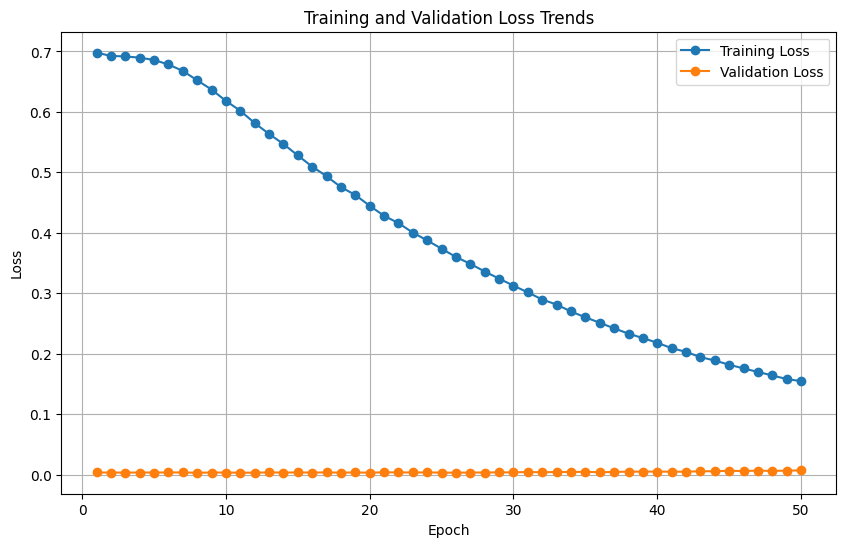

In [127]:
epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Trends")
plt.legend()
plt.grid(True)
plt.show()

In [128]:
model.eval()
with torch.no_grad():
  y_preds=[]
  for batch in val_data_loader:
    batch={k: v.to(device) for k, v in batch.items()}
    pred_labels=model(batch['embedding'])
    y_preds.extend(pred_labels.cpu().numpy().tolist())

In [129]:
y_preds=np.array(y_preds)
y_preds.shape

(4000, 1)

In [130]:
from sklearn.metrics import roc_auc_score
auc=roc_auc_score(y_val,y_preds,average=None)
df_accuracy = pd.DataFrame({"label": ["scores"], "auc": auc})
df_accuracy

,label,auc
0,scores,0.503533


In [131]:
def get_hate_score(sentence,model):
  padded_sent=torch.tensor(conv_to_tensor(sentence,100)).unsqueeze(dim=0).to(device)
  with torch.no_grad():
        embedding = bert_model(padded_sent)
  last_hidden_state = embedding.last_hidden_state
  df_conf=pd.DataFrame({"label": "scores", "confidence scores": model(last_hidden_state).cpu().detach().numpy()[0]})
  return df_conf


In [141]:
hate_models[1]['severe_toxic']['classifier']

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('classifier', SVC(kernel='linear', probability=True))])

In [144]:
all_hate_df.columns[1:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [149]:
model.load_state_dict(torch.load('best_model_epoch_25.pt',map_location=device))
model.eval()
sentence=process_text("The holocaust must not be repeated")
score=get_hate_score(sentence,model)['confidence scores'].iloc[0] #just a sample sentence, you can assign thresholds
result="Neutral" if 0.4<=score<=0.6 else ("Positive" if score>0.6 else "Negative")
print(result)
hate=list(all_hate_df.columns[1:])
friend=list(all_friendly_df.columns[1:])
if result=='Negative':
  for i in range(len(hate)):
    print(f"{hate[i]}: {classify_sentence(sentence,hate_models[i][hate[i]]['classifier'])['probability_scores'][1]}")
elif result=='Positive':
  for i in range(len(hate)):
    print(f"{friend[i]}: {classify_sentence(sentence,friend_models[i][friend[i]]['classifier'])['probability_scores'][1]}")

Positive
safe: 0.9628110482200736
mild: 0.9999943170248656
clean: 0.9946747237183067
safety: 0.9999999881393752
compliment: 0.8906197167860862
tolerance: 0.9999997236185938
